In [16]:
#general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import dill
from scipy.stats import uniform, randint

# preprocessing packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer

# pipeline tools
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, RepeatedKFold

# feature selection tools
from sklearn.feature_selection import VarianceThreshold, SelectKBest

#models
from xgboost import XGBRegressor

#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [22]:
# establish directory locations
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
data_folder = parent_directory + '/data/'
submissions_folder = parent_directory + '/submissions/'
models_folder = parent_directory + '/models/'

In [3]:
train_df = pd.read_csv(data_folder + 'train.csv')
test_df = pd.read_csv(data_folder + 'test.csv')

In [5]:
train_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


### Exploratory Data Analysis

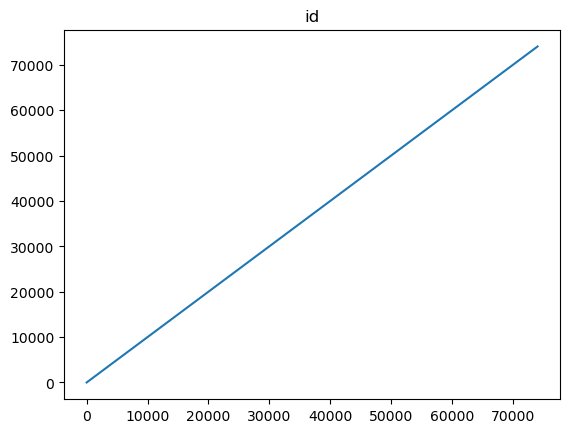

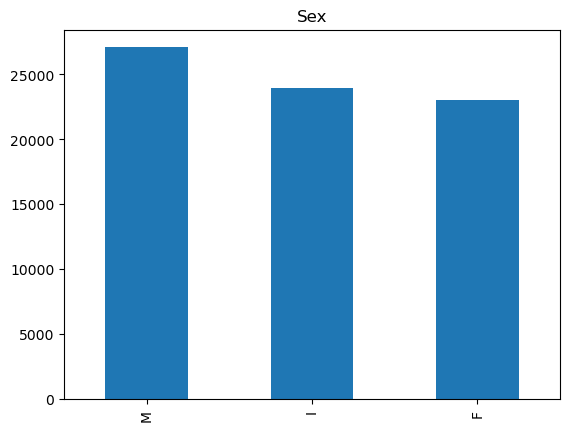

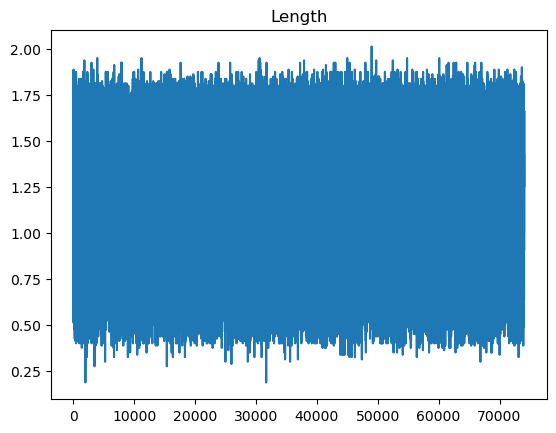

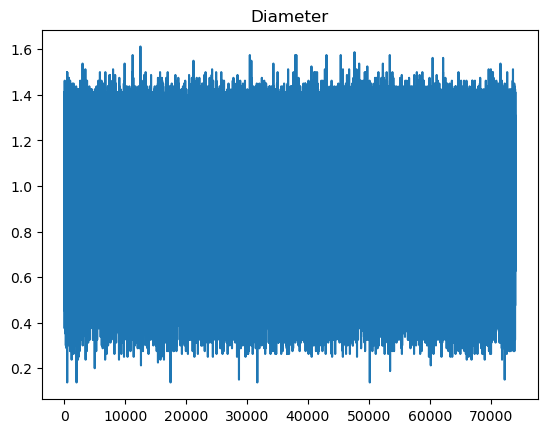

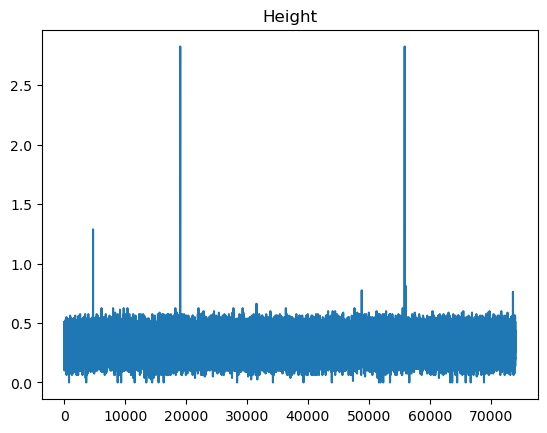

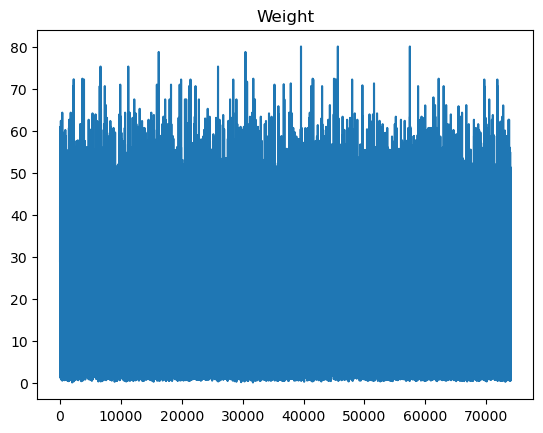

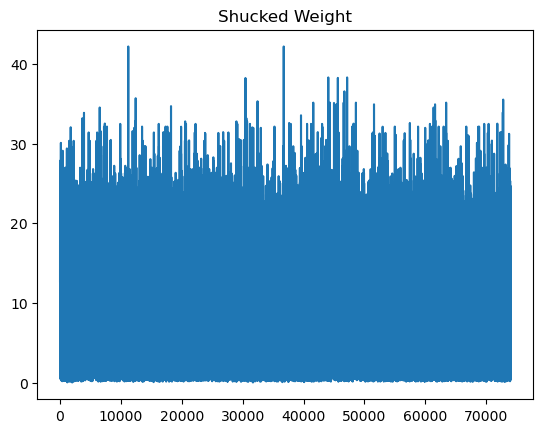

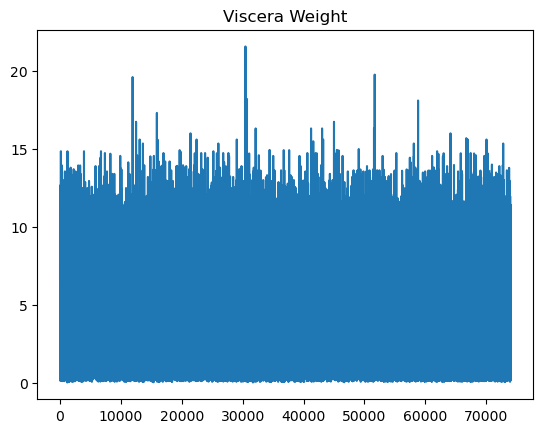

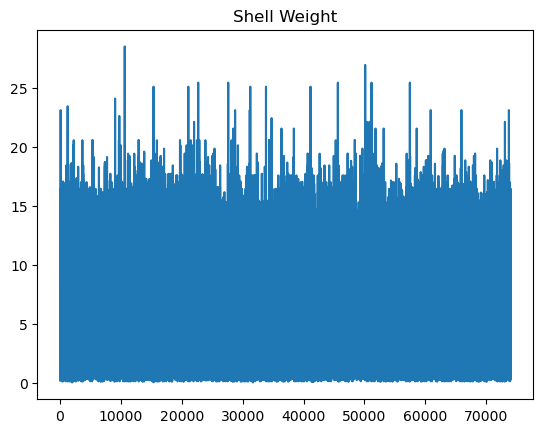

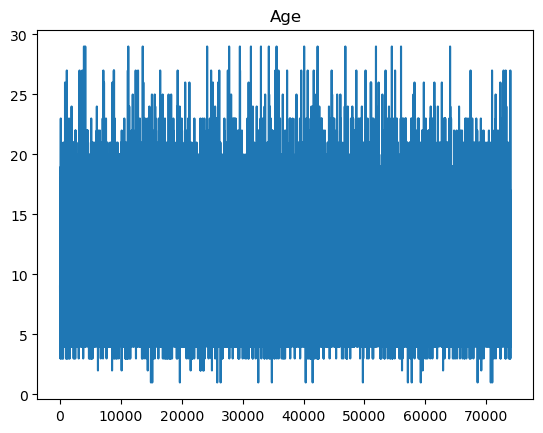

In [9]:
for column in train_df.columns:
    plt.figure()
    
    if np.issubdtype(train_df[column].dtype, np.number):
        train_df[column].plot()
    else:
        value_counts = train_df[column].value_counts()
        value_counts.plot(kind='bar')
    
    plt.title(column)
    plt.show()

In [10]:
corr = train_df.corr()
corr

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,1.000000,0.000165,0.000290,0.000967,-0.000910,-0.000801,-0.000640,-0.000816,0.000089
Length,0.000165,1.000000,0.989437,0.918352,0.936374,0.915516,0.917855,0.916957,0.612843
Diameter,0.000290,0.989437,1.000000,0.921353,0.938249,0.914199,0.918351,0.922688,0.621256
Height,0.000967,0.918352,0.921353,1.000000,0.901775,0.864083,0.883127,0.903398,0.638067
Weight,-0.000910,0.936374,0.938249,0.901775,1.000000,0.971267,0.971062,0.965525,0.601195
Shucked Weight,-0.000801,0.915516,0.914199,0.864083,0.971267,1.000000,0.942626,0.910398,0.503320
Viscera Weight,-0.000640,0.917855,0.918351,0.883127,0.971062,0.942626,1.000000,0.933919,0.576808
Shell Weight,-0.000816,0.916957,0.922688,0.903398,0.965525,0.910398,0.933919,1.000000,0.663473
Age,0.000089,0.612843,0.621256,0.638067,0.601195,0.503320,0.576808,0.663473,1.000000


### Baseline Solution

In [12]:
# specifying predictive and target features / train/test split
X_train = train_df.drop(columns = ['id', 'Age'])
y_train = train_df[['Age']]

X_output = pd.DataFrame(test_df['id'])
X_inf = test_df.drop(columns = ['id'])

In [13]:
# generate list of categorical feature names
categorical = []

for column in X_train.columns:
    if X_train[column].dtype == 'object':
        categorical.append(column)

print(categorical)

['Sex']


In [14]:
# generate list of numerical features
numerical = []

for column in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[column]):
        numerical.append(column)

print(numerical)

['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']


In [17]:
# Categorical pipeline
categoric_pipe = Pipeline([('categoric_encoder', OneHotEncoder())])

# Numeric pipeline:
numeric_pipe = Pipeline([('numeric_scaler', MinMaxScaler())])

pipeline = Pipeline([('column_transformer', ColumnTransformer([('categoric_pipe', categoric_pipe, categorical),
                                                               ('numeric_pipe', numeric_pipe, numerical)])),
                     ('xgBoost', XGBRegressor(objective = 'reg:squarederror',
                                              tree_method = 'gpu_hist'))])

In [20]:
search_space = [{'xgBoost__n_estimators': randint(10, 1000),
                 'xgBoost__learning_rate': uniform(0.01, 0.3),
                 'xgBoost__max_depth': randint(3, 10),
                 'xgBoost__colsample_bytree': uniform(0.3, 0.5),
                 'xgBoost__gamma': uniform(0, 10),
                 'xgBoost__reg_alpha' : uniform(0.00001, 0.3),
                 'xgBoost__reg_lambda' : uniform(0.00001, 0.3)}]

kfold = RepeatedKFold(n_splits=5,
                      n_repeats=3,
                      random_state=123)

xgb = RandomizedSearchCV(pipeline,
                         param_distributions = search_space,
                         n_iter = 10,
                         cv = kfold,
                         n_jobs = -1,
                         scoring = 'neg_root_mean_squared_error',
                         random_state=123)
xgb.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % xgb.best_score_)
print(xgb.best_params_)

Best parameter (CV score=-2.048):
{'xgBoost__colsample_bytree': 0.6612216912851108, 'xgBoost__gamma': 3.2295891385317823, 'xgBoost__learning_rate': 0.11853659668669422, 'xgBoost__max_depth': 6, 'xgBoost__n_estimators': 300, 'xgBoost__reg_alpha': 0.0881242139166488, 'xgBoost__reg_lambda': 0.18930283715634633}


### Write Pipeline to File

In [21]:
xgb_best_pipeline = xgb.best_estimator_

In [23]:
with open(models_folder + 'xgb.pkl', 'wb') as f:
    dill.dump(xgb_best_pipeline, f)

### Output Submission Files

In [24]:
X_output['pred'] = xgb_best_pipeline.predict(X_inf)

In [25]:
X_output

,id,pred
0,74051,7.590805
1,74052,7.587374
2,74053,10.682597
3,74054,9.529446
4,74055,7.435986
...,...,...
49363,123414,9.810603
49364,123415,8.185118
49365,123416,13.139222
49366,123417,9.857342


In [27]:
X_output[['id', 'pred']].to_csv(submissions_folder + 'V1_XGBoost.csv',
                                header = ['id', 'Age'],
                                index = False)